In [ ]:
#pip install geopy

In [ ]:
#pip install 

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Photon

from datetime import datetime
from meteostat import Point, Daily, Hourly

In [2]:
cri_data = pd.read_csv('cri_data.csv')

In [3]:
geolocator = Photon(user_agent="measurements")
def fetch_coordinates(country_name):
    try:
        location = geolocator.geocode(country_name)
        if location:
            return (location.latitude, location.longitude)
        else:
            return (None, None)
    except GeocoderTimedOut:
        return (None, None)

In [4]:
def fetch_temperature_data(latitude, longitude, start_date_str, end_date_str, frequency='daily'):
    # Convert date strings to datetime objects
    start_date = datetime.strptime(start_date_str, '%Y-%m-%d')
    end_date = datetime.strptime(end_date_str, '%Y-%m-%d')

    location = Point(latitude, longitude)
    if frequency == 'daily':
        data = Daily(location, start_date, end_date)
    elif frequency == 'hourly':
        data = Hourly(location, start_date, end_date)
    else:
        raise ValueError("invalid frequency")
    return data.fetch()

temperature_data = {}
for country in tqdm(cri_data['Country'].unique()):
    lat, lon = fetch_coordinates(country)
    if lat is not None and lon is not None:
        #since the climate risk index data is measured in 2018
        temp_data = fetch_temperature_data(lat, lon, '2018-01-01', '2018-12-31')
        temperature_data[country] = temp_data

100%|█████████████████████████████████████████| 183/183 [01:13<00:00,  2.48it/s]


In [5]:
def calculate_metrics(temp_data):
    # Using average temperature ('tavg') for calculations
    mean_temp = temp_data['tavg'].mean()
    var_temp = temp_data['tavg'].var()
    std_temp = temp_data['tavg'].std()
    mean_tmin = temp_data['tmin'].mean()
    mean_tmax = temp_data['tmax'].mean()
    mean_range = (temp_data['tmax']-temp_data['tmin']).mean()
    # We define extremes using the average temperature by 2 times more extreme than the mean of tmax/tmin
    extreme_hot_threshold = mean_tmax + 2 * std_temp
    extreme_cold_threshold = mean_tmin - 2 * std_temp 
    extreme_hot_freq = (temp_data['tmax'] > extreme_hot_threshold).sum()
    extreme_cold_freq = (temp_data['tmin'] < extreme_cold_threshold).sum()
    return mean_temp, var_temp, extreme_hot_freq, extreme_cold_freq, mean_range

metrics_data = {country: calculate_metrics(data) for country, data in tqdm(temperature_data.items())}

100%|███████████████████████████████████████| 183/183 [00:00<00:00, 2711.32it/s]


In [17]:
metrics_df = pd.DataFrame.from_dict(metrics_data, orient='index', 
                                    columns=['Mean_Temp', 'Var_Temp', 'Extreme_Hot_Freq', 'Extreme_Cold_Freq', 'Mean_Range'])

# merge with cri_data
combined_data = pd.merge(cri_data[['Country', 'CRI\rscore', 'CRI\rRank']], metrics_df, left_on='Country', right_index=True)
combined_data = combined_data.rename(columns={'CRI\rscore': 'CRI_Score', 'CRI\rRank': 'CRI_Rank'})
combined_clean = combined_data.dropna()
correlations = combined_data.corr()

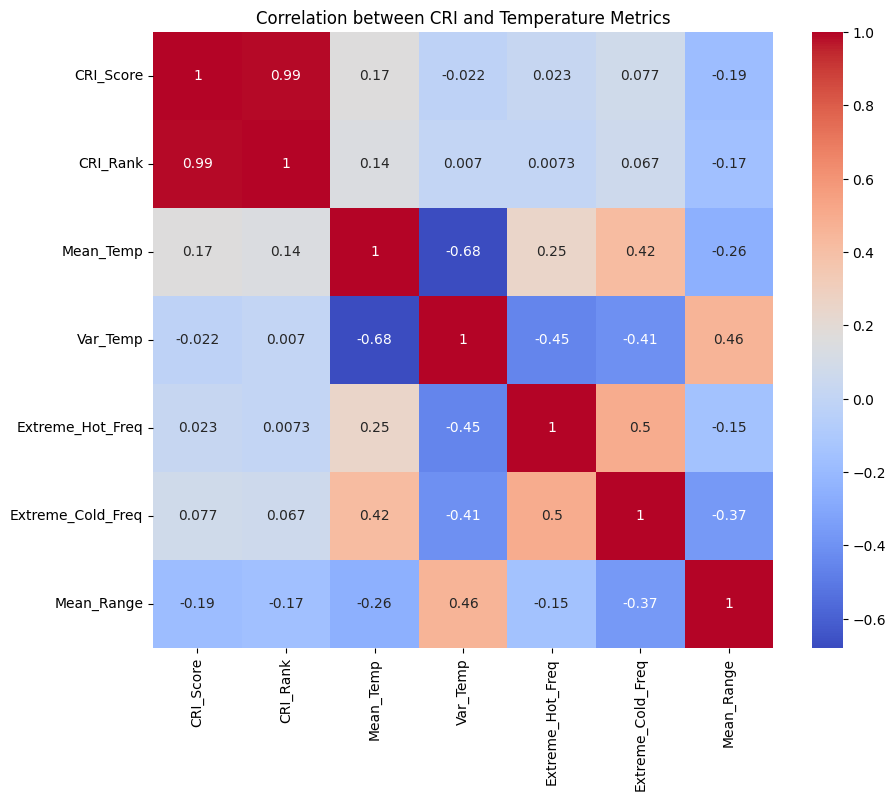

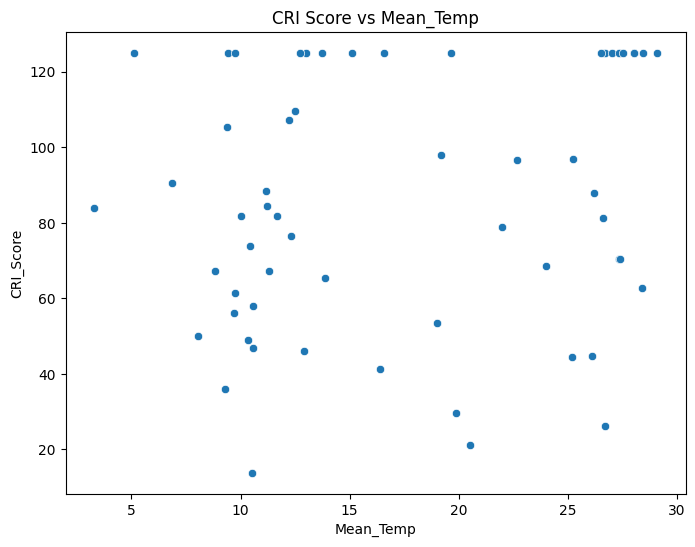

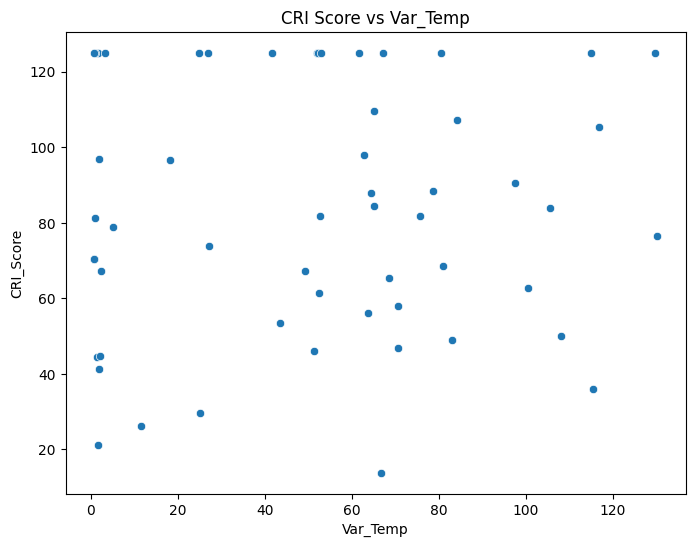

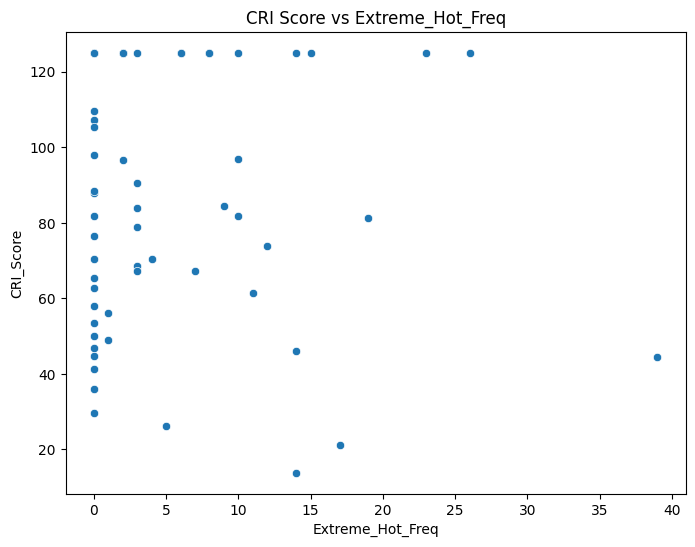

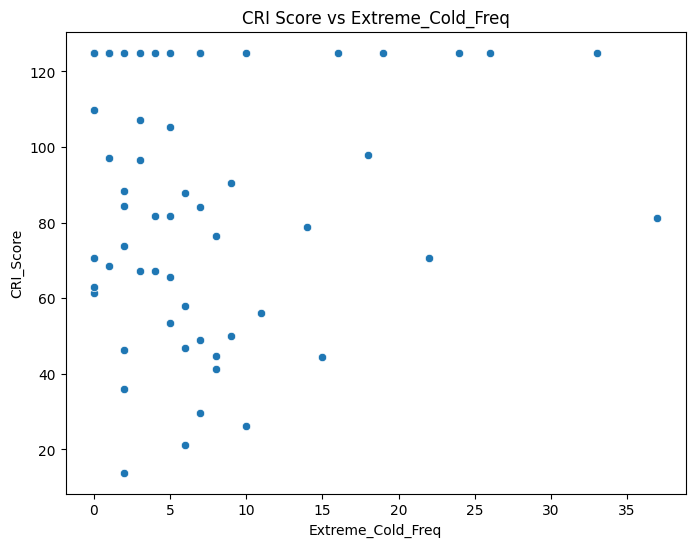

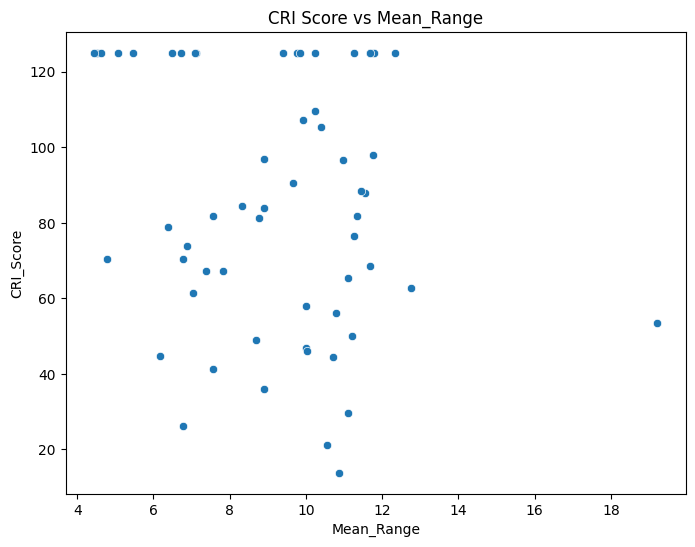

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation between CRI and Temperature Metrics')
#plt.savefig('heatmap.png')
plt.show()

for metric in ['Mean_Temp', 'Var_Temp', 'Extreme_Hot_Freq', 'Extreme_Cold_Freq', 'Mean_Range']:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=combined_clean, x=metric, y='CRI_Score')
    plt.title(f'CRI Score vs {metric}')
    plt.show()

In [19]:
combined_clean.to_csv('combined_clean.csv')

In [21]:
combined_clean.head()

,Country,CRI_Score,CRI_Rank,Mean_Temp,Var_Temp,Extreme_Hot_Freq,Extreme_Cold_Freq,Mean_Range
3,Antigua and Barbuda,125.0,135,26.694375,1.176018,2,26,4.520313
5,Armenia,125.0,135,9.416910,52.103397,6,1,11.684667
7,Austria,56.0,49,9.687009,63.694588,1,11,10.781873
8,Azerbaijan,125.0,135,16.553571,80.552246,6,0,10.247940
9,Bahrain,125.0,135,28.451507,41.610911,2,3,6.733426
